In [140]:
import numpy as np
from nbformat.sign import algorithms

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp, Statevector

# BFGS minimizer routine
from qiskit_algorithms.optimizers import L_BFGS_B

# Plotting functions
import matplotlib.pyplot as plt

# Global dictionary
cost_history_dict = {
	"prev_vector": None,
	"iters": 0,
	"cost_history": [],
}

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

# Variational Quantum Eigensolver

The VQE is the first type of hybrid quantum--classical which was proposed, and it is the first one we will deal with. The cost function in this case based on the Ritz variational principle, that is

\begin{equation}
    C(\boldsymbol{\theta}) = \bra{\psi(\boldsymbol{\theta})}\mathcal{H}\ket{psi(\boldsymbol{\theta})}.
\end{equation}

The minimum of this function is the ground-state energy:

\begin{equation}
    E_0 = \min_{\boldsymbol{\theta}}\bra{\psi(\boldsymbol{\theta})}\mathcal{H}\ket{psi(\boldsymbol{\theta})}.
\end{equation}

We thus have the first component of our VQA, the cost function. Let us now define it in terms of code


In [141]:
def cost_function(theta):
	circuit = ansatz.assign_parameters(theta)  # bind parameters to circuit
	statevector = Statevector(circuit)  # get statevector representation
	exp = statevector.expectation_value(hamiltonian).real  # evaluation expectation value
	
	cost_history_dict["iters"] += 1
	cost_history_dict["prev_vector"] = theta
	cost_history_dict["cost_history"].append(exp)
	
	print(f"Iter: {cost_history_dict['iters']}, Cost: {exp}")

	return exp

## Hamiltonian

Our next two components: the PQC and measurement strategy, may depend quite a bit on our Hamiltonian, and any constraints which we wish to satisfy (however for the sake of simplicity we will suppose that we have no extra constraints). However, for now we shall take statevector simulations, that is we assume that we have perfect information of the quantum state (we have access to its vector representation). Thus, we need not worry about the measurement technique yet. This is useful for prototyping your VQA, ensuring that everything works.

We shall take a simplified $H_2$ model at $0.735$Å, which can be written in Qiskit as

In [142]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

## Parameterized quantum circuit

Now let's proceed to use a simple two local ansatz, that is an ansatz which alternates between parameterized one-qubit gates, and (non-parameterized) two-qubit entangling gates

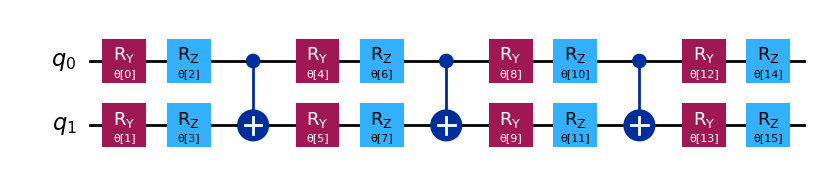

In [143]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

## Classical optimizer

As we said, for now shall focus on statevector simulations and not worry about measurements. The next step is then choose a classical optimizer. Qiskit has many optimizers to choose from. Quite a bit of them are based on Scipy's implementations. We will take the L-BFGS-B optimizer for the time being.

In [144]:
optimizer = L_BFGS_B()

## Putting it all together

We now just need to run the algorithm optimizing through to get our ground-state energy

In [145]:
x0 = np.random.uniform(-np.pi, np.pi, len(ansatz.parameters))  # We need an initial point (which can be random)

result = optimizer.minimize(fun=cost_function, x0=x0)

print(result)

Iter: 1, Cost: 0.24333132723782414
Iter: 2, Cost: 0.24333133047472477
Iter: 3, Cost: 0.24333133129426962
Iter: 4, Cost: 0.24333132615131547
Iter: 5, Cost: 0.24333132949044955
Iter: 6, Cost: 0.24333132976764626
Iter: 7, Cost: 0.24333132738433244
Iter: 8, Cost: 0.24333132619487585
Iter: 9, Cost: 0.2433313291637067
Iter: 10, Cost: 0.2433313228442534
Iter: 11, Cost: 0.2433313228181852
Iter: 12, Cost: 0.24333132851095474
Iter: 13, Cost: 0.2433313289493631
Iter: 14, Cost: 0.24333132469430088
Iter: 15, Cost: 0.2433313289973077
Iter: 16, Cost: 0.24333132638107255
Iter: 17, Cost: 0.24333132475629038
Iter: 18, Cost: -0.5169059988600396
Iter: 19, Cost: -0.516905997664119
Iter: 20, Cost: -0.5169059989977125
Iter: 21, Cost: -0.5169059982926109
Iter: 22, Cost: -0.5169059983989454
Iter: 23, Cost: -0.5169059975745571
Iter: 24, Cost: -0.5169059984154509
Iter: 25, Cost: -0.5169059983891413
Iter: 26, Cost: -0.5169059989589309
Iter: 27, Cost: -0.516905998793727
Iter: 28, Cost: -0.5169059987696271
Iter: 29

## Understanding the Results

The above result shows us:
- `fun`: the final optimised cost.
- `nfev`: the amount of function evaluations, i.e. evaluations of the  cost function.
- `jac`: if a jacobian function was used (in this case we did not use one, and we used finite differences to evaluate the gradient).
- `nit`: the number of iterations, i.e. the number of times the minimum was updated.
- `njev`: the number of times the gradient was evaluated.
- `x`: the final optimized parameters for our PQC.

Let us now plot some results.

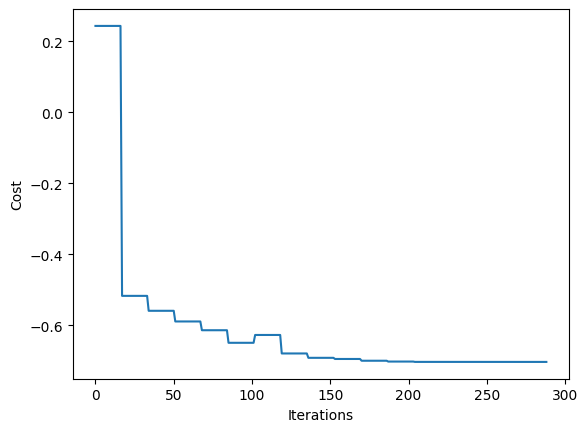

In [146]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

## Looking at the Plot

We can see the cost decreasing as the number of iterations increase. Now how do we confirm that we have achieved the minimum?

For small problems we can compute the minimum by diagonalizing the Hamiltonian.

-0.702930394459531


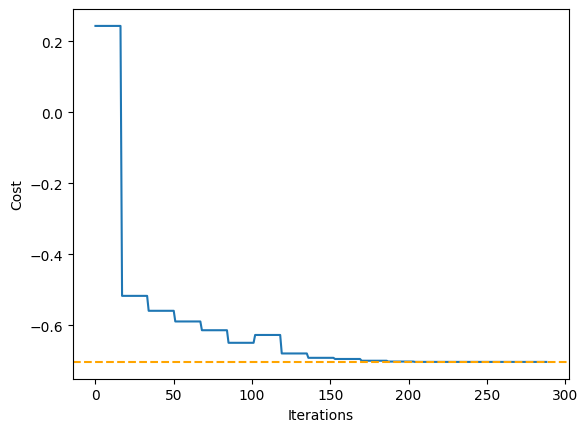

In [147]:
# Getting eigenvalues and eigenvectors from the hamiltonian
u, v = np.linalg.eigh(hamiltonian)

# Printing lowest eigenvalue
print(min(u))

# Updating plot
ax.axhline(y = min(u), color='orange', linestyle = '--')
fig

# We can now see that the minimum is achieved!

Now try to experiment with changing the optimizer (remember to import them from qiskit_algorithms.optimizers):

You can find a list of them supported by `Qiskit` [here](https://qiskit-community.github.io/qiskit-algorithms/apidocs/qiskit_algorithms.optimizers.html).

Gradient-based:
- GradientDescent: typical gradient descent method.
- `SPSA`: a stochastic method.

Gradient-free:
- `NELDER_MEAD`: simplex method.
- `COBYLA`: constrained optimization by linear approximation.

In [148]:
# from qiskit_algorithms.optimizers import <optimizer>
# 
# optimizer = <optimizer>()
# result = optimizer.minimize(fun=cost_function, x0=x0)
# 
# print(result)
# 
# fig, ax = plt.subplots()
# ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
# ax.axhline(y = min(u), color='orange', linestyle = '--')
# ax.set_xlabel("Iterations")
# ax.set_ylabel("Cost")
# plt.draw()